# Blog Text-Classification using Logistic Regression

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asakinnubi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
dataset = pd.read_csv('../data/Indo-pacific-processed-post-emotions.csv')
dataset.head()

,Unnamed: 0.1,Unnamed: 0,blogpost_id,title,date,blogger,tags,sentiment,location,blog_post_processed,emotion,emotions_score
0,0,0,1,Ukraine and the ‘New Cold War: The Return of N...,2014-06-04 00:00:00,Matt Finucane,"Crimea, EU, Finland, Hungary, IMF, Neutralism,...",-0.353554,ES,whether the crimean crisis heralds a new era o...,fear,0.340458
1,1,1,2,Guest Post: China and the Crimea Conundrum,2014-03-12 00:00:00,Matt Finucane,"China, Crimea, Putin, Russia, Tibet, Uighurs, ...",-0.177808,ES,with the eu-us alliance’s imposition of heavy ...,fear,0.344225
2,2,2,3,Power vs. Interest: Ukraine’s Dwindling Options,2014-03-02 00:00:00,Matt Finucane,"Crimea, Euromaidan, Invasion, Lithuania, NATO,...",-0.175542,ES,predictions regarding ukraine’s future followi...,fear,0.438030
3,3,3,4,Hanging in the Balance: Ukraine’s Russian Repu...,2014-03-01 00:00:00,Matt Finucane,"Crimea, EU, Euromaidan, Invasion, NATO, Putin,...",-0.212766,ES,over the past four or so months ukraine has wi...,disgust,0.902291
4,4,4,5,Two Very Different Wars on Terrorism: How the ...,2014-02-03 00:00:00,Matt Finucane,"Afghanistan, bombings, Chechnya, Doku Umarov, ...",-0.197037,ES,on the 29th of december at 12:40 moscow time a...,anticipation,0.461333


In [13]:
dataset = dataset.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

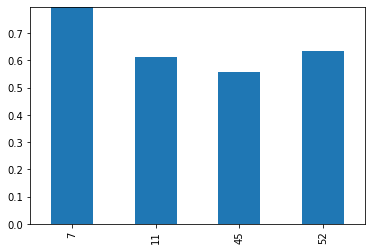

In [18]:
dataset.groupby('emotion').emotions_score.plot.bar(ylim=0)
plt.show()

In [19]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
dataset['cleaned'] = dataset['blog_post_processed'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asakinnubi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
dataset.head()

,blogpost_id,title,date,blogger,tags,sentiment,location,blog_post_processed,emotion,emotions_score,cleaned
0,1,Ukraine and the ‘New Cold War: The Return of N...,2014-06-04 00:00:00,Matt Finucane,"Crimea, EU, Finland, Hungary, IMF, Neutralism,...",-0.353554,ES,whether the crimean crisis heralds a new era o...,fear,0.340458,whether crimean crisi herald new era intern re...
1,2,Guest Post: China and the Crimea Conundrum,2014-03-12 00:00:00,Matt Finucane,"China, Crimea, Putin, Russia, Tibet, Uighurs, ...",-0.177808,ES,with the eu-us alliance’s imposition of heavy ...,fear,0.344225,eu us allianc imposit heavi sanction russia de...
2,3,Power vs. Interest: Ukraine’s Dwindling Options,2014-03-02 00:00:00,Matt Finucane,"Crimea, Euromaidan, Invasion, Lithuania, NATO,...",-0.175542,ES,predictions regarding ukraine’s future followi...,fear,0.438030,predict regard ukrain futur follow russian inv...
3,4,Hanging in the Balance: Ukraine’s Russian Repu...,2014-03-01 00:00:00,Matt Finucane,"Crimea, EU, Euromaidan, Invasion, NATO, Putin,...",-0.212766,ES,over the past four or so months ukraine has wi...,disgust,0.902291,past four month ukrain wit protest riot dwarf ...
4,5,Two Very Different Wars on Terrorism: How the ...,2014-02-03 00:00:00,Matt Finucane,"Afghanistan, bombings, Chechnya, Doku Umarov, ...",-0.197037,ES,on the 29th of december at 12:40 moscow time a...,anticipation,0.461333,th decemb moscow time explos gut entranc volgo...


In [21]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(dataset['cleaned']).toarray()
final_features.shape

(200, 3052)

C:\Users\asakinnubi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asakinnubi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asakinnubi\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         3
anticipation       0.00      0.00      0.00        10
     disgust       0.00      0.00      0.00         1
        fear       0.00      0.00      0.00         8
         joy       0.52      1.00      0.68        26
     sadness       0.00      0.00      0.00         1
    surprise       0.00      0.00      0.00         1

    accuracy                           0.52        50
   macro avg       0.07      0.14      0.10        50
weighted avg       0.27      0.52      0.36        50

[[ 0  0  0  0  3  0  0]
 [ 0  0  0  0 10  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  8  0  0]
 [ 0  0  0  0 26  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  1  0  0]]


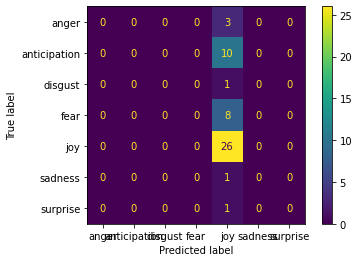

In [23]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X = dataset['cleaned']
Y = dataset['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))
plot_confusion_matrix(model, X_test, ytest)  
plt.show()